### Exploring the annotated data.

In [1]:
from datasets import load_dataset, disable_caching
import pandas as pd

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
ds = load_dataset("json", data_dir="./data/annotated/", download_mode="force_redownload", cache_dir=None)
# ds = load_dataset("json", data_dir="./data/annotated_test/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
        num_rows: 19622
    })
})

In [2]:
# fewer than 6k unique authors in shaders20k
df["author"].nunique()

5924

In [3]:
#redo the df

df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
#

In [4]:
df["test"].value_counts().head(10)

test
ok          8550
error       5011
valid       4347
timeout     1690
timedout      24
Name: count, dtype: int64

In [5]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))

824


In [19]:

print(ds["train"].unique("license"))
# filter permissive licenses
filtered_ds = ds["train"].filter(lambda x: x["license"] in permissive_list + ["CC-BY-NC-SA-3.0"]) # permissive or base case(not actually permissive...) what about those AND and OR classifications?
filtered_ds = filtered_ds.filter(lambda x: x["test"] == "ok") # ok means it actually runs, valid was just that naga didn't error... but this also has issues
filtered_ds = filtered_ds.filter(lambda x: x["published"] == "Public API") # naga is the author of the test cases
filtered_ds

['CC-BY-NC-SA-3.0', 'warranty-disclaimer', 'apache-2.0', 'cc0-1.0', 'cc-by-nc-sa-3.0', 'wtfpl-2.0', 'mit', 'cc-by-4.0', 'cc-by-nc-4.0', 'cc-by-sa-4.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'cc-by-3.0', 'cc-by-sa-3.0', 'gpl-2.0-plus', 'gpl-3.0', 'cc-by-nc-sa-4.0', 'proprietary-license', 'bsd-simplified', 'public-domain', 'unknown-license-reference', 'gpl-3.0-plus', 'cc-by-nc-3.0', 'gpl-1.0-plus', 'artistic-2.0', 'cc-sampling-plus-1.0', 'bsd-new', 'cc-by-nc-nd-3.0', 'agpl-3.0', 'cc-by-sa-2.5', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-4.0 OR cc-by-3.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'unlicense', 'cc-by-nc-nd-4.0', 'x11', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-2.0']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17806 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7910 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 2523
})

In [20]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

['']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 0
})

<Axes: title={'center': 'license'}, xlabel='date'>

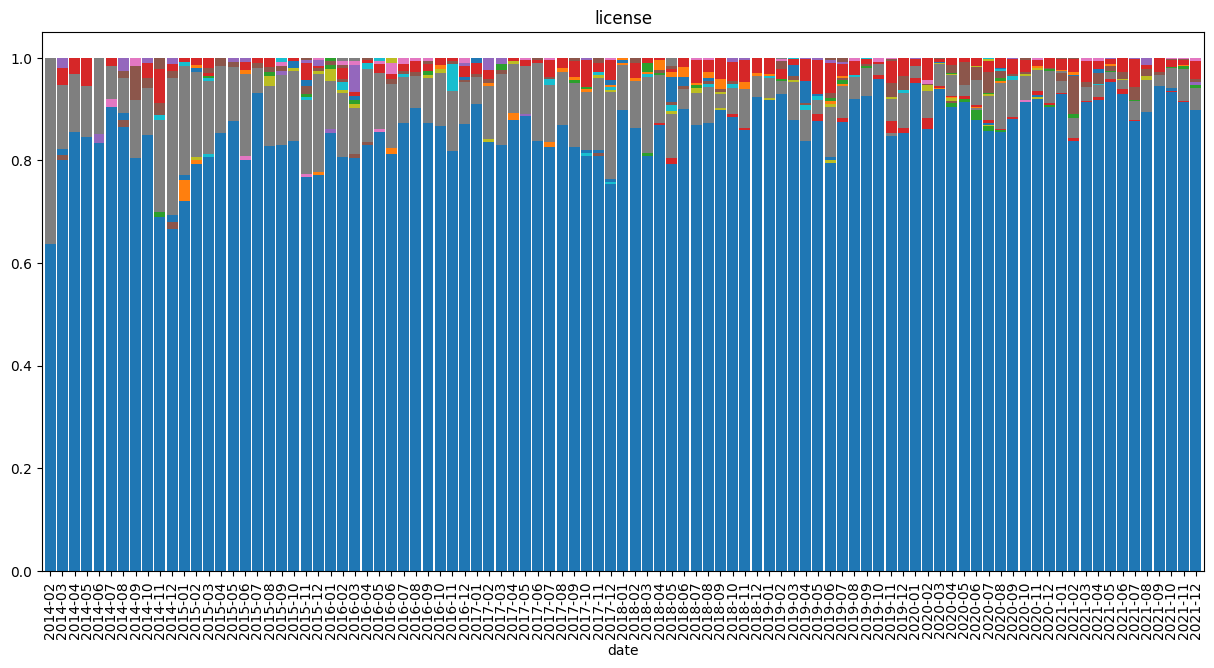

In [21]:
def plot_per_month(column, stretched=False, **kwargs):
    feature_df = df["date"].groupby([df["date"].dt.to_period("M"), df[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
plot_per_month("license", True, legend=False)

<Axes: title={'center': 'published'}, xlabel='date'>

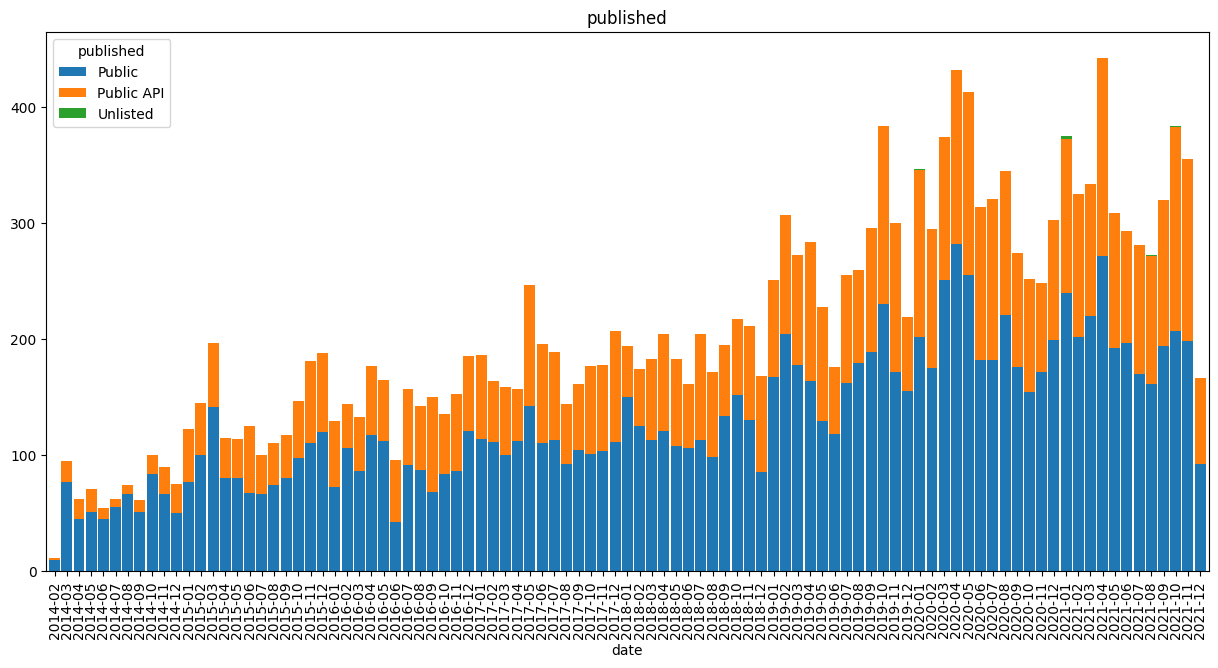

In [22]:
plot_per_month("published", False)

<Axes: title={'center': 'test'}, xlabel='date'>

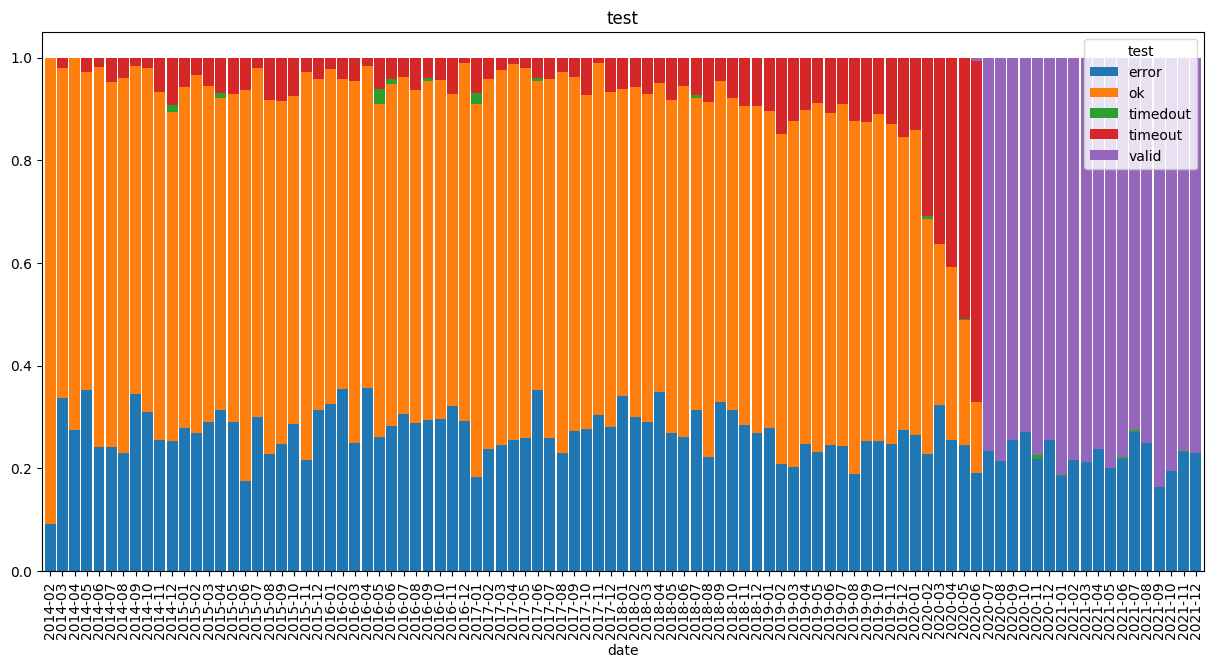

In [23]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

In [24]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         7.946234
std         10.261134
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        344.000000
Name: num_functions, dtype: float64

<Axes: title={'center': 'num_inputs'}, xlabel='date'>

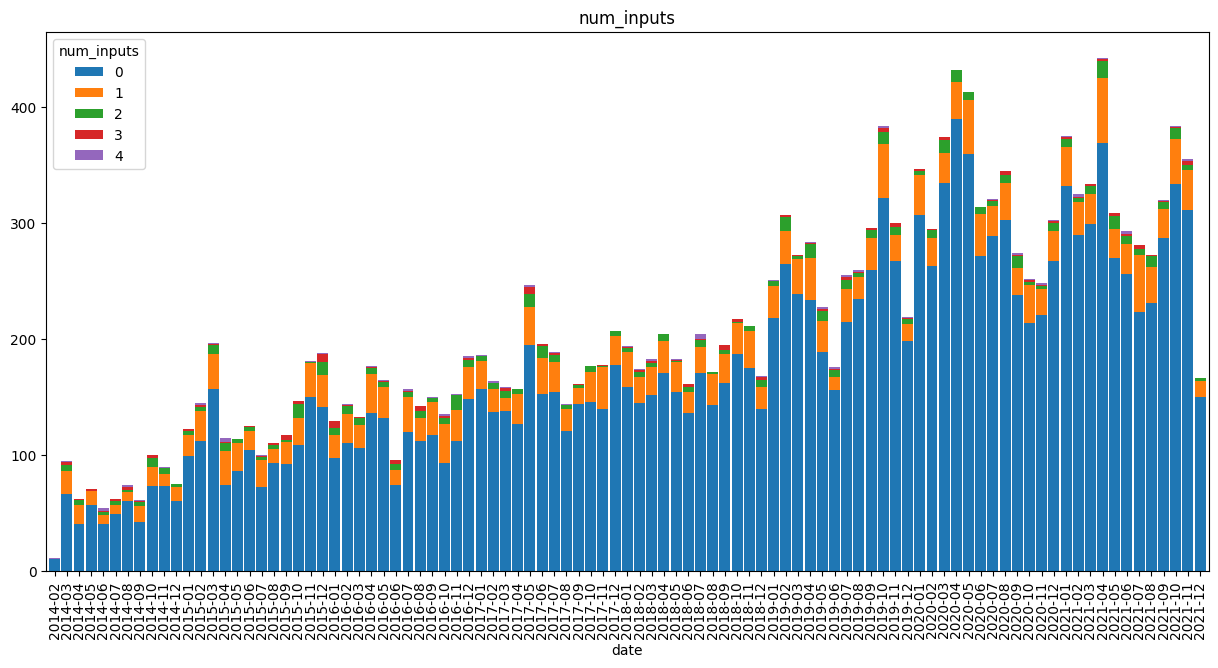

In [25]:
df["num_inputs"] = df["image_inputs"].apply(len)
plot_per_month("num_inputs", stretched=False, legend=True)

In [26]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][19616],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

False


,id,name,author,description,tags,likes,viewed,published,date,time_retrieved,...,buffer_d_inputs,cube_a_code,cube_a_inputs,thumbnail,access,license,functions,test,num_functions,num_inputs
62,3tBczh,Mellifera I,sl2c,Apparently this construction on a right-angled...,"[circles, hyperbolic, horosphere]",9,133,Public,2020-07-06 22:09:24,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/3tBczh...,shaders20k,apache-2.0,[],error,0,0
75,3tjyDR,circle vs spiral illusion (203),FabriceNeyret2,reference:\n[img]https://i.redd.it/7zm03eo01ma...,"[illusion, 2tweets, perception, short, golf]",13,240,Public API,2020-07-07 13:15:08,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/3tjyDR...,shaders20k,CC-BY-NC-SA-3.0,[],valid,0,0
169,WdXfD4,Tutorial from progur,landicefu,https://progur.com/2017/03/how-to-create-anima...,[tutorial],1,158,Public API,2020-07-03 04:11:21,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/WdXfD4...,shaders20k,CC-BY-NC-SA-3.0,[],valid,0,0
328,3l2fzw,Polar Weave Pattern - simple 2,FabriceNeyret2,golfed variant of [url]https://shadertoy.com/v...,"[2d, repetition, pattern, polar, 2tweets, shor...",7,156,Public API,2020-08-27 17:47:41,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/3l2fzw...,shaders20k,CC-BY-NC-SA-3.0,[],valid,0,0
640,wtSfDR,Polar Weave Pattern - simple 3,FabriceNeyret2,asymmetrical variant\ngolfed variant of [url]h...,"[2d, repetition, pattern, polar, short, weave]",6,207,Public API,2020-08-28 19:16:51,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/wtSfDR...,shaders20k,CC-BY-NC-SA-3.0,[],valid,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19110,tsXfWS,Dodecahedralis II,sl2c,A hyperbolic 3-manifold sliced along a horosph...,"[circles, tiling, hyperbolic, horosphere]",20,172,Public,2020-05-11 16:05:45,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/tsXfWS...,shaders20k,apache-2.0,[],error,0,0
19115,wd2fRW,Bap,Bjorn,I'm stuck on oldschool 2D effects.\nI think th...,[chessboard],5,112,Public,2020-05-23 13:59:33,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/wd2fRW...,shaders20k,CC-BY-NC-SA-3.0,[],timeout,0,0
19173,wdlfD2,Hyperbolic bloom,sl2c,A horospherical slice a la Bulatov as in [url=...,"[hyperbolic, horosphere]",12,157,Public,2020-05-13 16:32:20,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/wdlfD2...,shaders20k,apache-2.0,[],timeout,0,0
19519,wllyzN,"fork, strange",Carandiru,"had to try it out, don't know why I ended up h...",[forkntsutaescircuitdiagram2v1],1,227,Public API,2020-06-08 10:13:05,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/wllyzN...,shaders20k,CC-BY-NC-SA-3.0,[],error,0,1


In [27]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids = [],[],[]
    for code, func_bytes, shader_id in zip(batch["image_code"], batch["functions"], batch["id"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = filtered_ds.map(split_functions, batched=True, remove_columns=filtered_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

Map:   0%|          | 0/2523 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
    num_rows: 13036
})

In [28]:
func_df = func_ds.to_pandas()
func_df.head() 

,id,comment,header,docstring,body,full_code,func_bytes
0,XsS3DV,,"vec2 center ( vec2 border , vec2 offset , vec2...",,\n\tvec2 c;\n\tif ( vel.x == 0.0 && vel.y == 0...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[49, 49, 103, 103, 506]"
1,XsS3DV,,"void circle ( float r , vec3 col , vec2 offset...",,\n\tvec2 pos = coord.xy / iResolution.y;\n\tfl...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[508, 508, 569, 569, 797]"
2,XsS3DV,,"vec3 band ( float shade, float low, float high...",,\n\n\tif ( (shade >= low) && (shade <= high) )...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[800, 800, 872, 872, 1067]"
3,XsS3DV,,vec3 gradient ( float shade ) {,,\n\tvec3 colour = vec3( (sin(iTime/2.0)*0.25)+...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[1069, 1069, 1100, 1100, 1876]"
4,XsS3DV,,"void mainImage( out vec4 fragColor, in vec2 fr...",,\n\n coord = fragCoord;\n \n\tcircle ( ....,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[1878, 1878, 1935, 1935, 2619]"


In [29]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both... and 150 for valid shaders only.

functions with context = 2915


has_docstring,False,True,All
has_comment,,,
False,10121,847,10968
True,1835,233,2068
All,11956,1080,13036


In [30]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

1604


comment
                                                                           10968
// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\n              9
// polynomial smooth min (k = 0.1);\n                                          8
// Scene setup\n                                                               7
//hash function by Dave_Hoskins https://www.shadertoy.com/view/4djSRW\n        7
// vec2 to vec2 hash.\n                                                        7
// Standard 2D rotation formula.\n                                             7
// 1 / z\n                                                                     6
// Inspired by @cabbibo\n// https://www.shadertoy.com/view/Xl2XWt\n            6
//original code from : http://www.chilliant.com/rgb2hsv.html\n                 6
Name: count, dtype: int64

In [31]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

7457


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    1454
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      142
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{       108
void mainImage(out vec4 fragColor, in vec2 fragCoord) {         83
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        74
float sdBox( vec3 p, vec3 b )\n{                                54
vec3 calcNormal( in vec3 pos )\n{                               43
void mainImage( out vec4 O, vec2 U )\n{                         37
float map(vec3 p)\n{                                            35
float map(vec3 p) {                                             33
Name: count, dtype: int64

In [32]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

2379

In [33]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

734


docstring
                                                                                  11956
\n    // Normalized pixel coordinates (from 0 to 1)                                 165
\n\n    // Precompute values for skewed triangular grid                              10
\n    \n    //numerator /= (abs(denominator)+1.0);                                    8
\n    // normalized pixel coordinates                                                 8
\n\n    // Screen coordinates.                                                        6
\n    // filter kernel                                                                6
\n    \n    // Normalized pixel coordinates (from 0 to 1)                             6
 // in [0,1]                                                                          6
\n    /////////////////////////////////\n    // TASK: WRITE YOUR CODE HERE. //        4
Name: count, dtype: int64

In [34]:
# indicator where the docstring is just something commented out - not helpful instructions.
func_df["docstring"].str.endswith(";").sum()

111

In [35]:
# the comment is just a link to some website/reference? although sometimes it's a bunch of natural langauge too?
print(func_df["comment"].str.contains("https://").sum())
print(func_df["comment"].str.contains("www.").sum())

222
270


In [36]:
# proposed model_ctx takes all of them in normal order (doens't filter out the naked functions)
print(func_df["model_ctx"].nunique())
func_df["model_ctx"].value_counts(sort=True, ascending=False).head(10)

7846


model_ctx
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    1423
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      139
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{       107
void mainImage(out vec4 fragColor, in vec2 fragCoord) {         80
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        72
float sdBox( vec3 p, vec3 b )\n{                                52
void mainImage( out vec4 O, vec2 U )\n{                         37
vec3 calcNormal( in vec3 pos )\n{                               35
float map(vec3 p)\n{                                            33
float map(vec3 p) {                                             31
Name: count, dtype: int64

In [37]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                                                                                                          9
vec2 hash22(vec2 p) {                                                                                                                                               8
float noise3D(vec3 p){                                                                                                                                              5
float checkersGradBox( in vec2 p )\n{                                                                                                                               4
float F ( in vec2 coords )\n{                                                                                                                                       3
float snoise(vec2 v) {                                                                                                                                             

In [38]:
len(both_df)

233

In [39]:
# this step can timeout/hang -.-
# step 2. if code runs without the function.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:] #TODO: this needs to be done in bytes -.-
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

C:\Users\Jan\AppData\Local\Temp\ipykernel_10516\4005513836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df["needed"] = both_df.apply(check_function_needed, axis=1)


needed
True     227
False      6
Name: count, dtype: int64

In [28]:
# step 3. check if the whole code works originally (we filtered for valid only) (this is redundant)

def check_code(row):
    code = row["full_code"]
    status = run_shader(code)
    return status

both_df["status"] = both_df.apply(check_code, axis=1)

C:\Users\Jan\AppData\Local\Temp\ipykernel_11244\902904704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df["status"] = both_df.apply(check_code, axis=1)


In [40]:
# down select the only the needed and working examples.
print(len(both_df))
both_df = both_df.loc[both_df["needed"]]
len(both_df)

233


227

In [41]:
from datasets import Dataset

both_df.loc[:,"input_both"] = both_df["comment"] + both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_comment"] = both_df["comment"] + both_df["header"]
both_df.loc[:,"input_docstring"] = both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_none"] = both_df["header"]
print(both_df.shape)
print(both_df["input_both"].nunique())
# remove the duplicates
both_df.drop_duplicates("input_both", inplace=True)
experiment_ds = Dataset.from_pandas(both_df)
experiment_ds

(227, 15)
203


Dataset({
    features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes', 'has_comment', 'has_docstring', 'model_ctx', 'needed', 'input_both', 'input_comment', 'input_docstring', 'input_none', '__index_level_0__'],
    num_rows: 203
})

In [31]:
# this pushes the dataset to the hub, uncomment with care!
# experiment_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", private=False, commit_message="v0.2 has 986 rows, includes base license")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Vipitis/Shadereval-experiments-dev/commit/3a915c11eb6445642f2d043624ae579489a0534d', commit_message='v0.2 has 986 rows, includes base license', commit_description='', oid='3a915c11eb6445642f2d043624ae579489a0534d', pr_url=None, pr_revision=None, pr_num=None)